# Face the Data Training: Algorithms to Decode Human Emotions
First thing we need to do is to import our data.

We downloaded the dataset as a zip file from: https://www.kaggle.com/datasets/msambare/fer2013?resource=download. We then need to unzip the file and make sure that the data is accessible!
We also need to import all the necessary tools for the project!

In [38]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

import zipfile
import os
from PIL import Image
import keras
import shutil
from sklearn.model_selection import train_test_split
from pathlib import Path
from keras import layers
from keras import models
from keras import optimizers

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import LambdaCallback

# Facing the Data
Let's start investigating our data set! We need to first import our data and split it. After that, we can preprocess our data and get a look of what our dataset looks like.

In [47]:
# extracting files
with zipfile.ZipFile("fer2013.zip", "r") as zip_ref:
    zip_ref.extractall("fer2013_data")

# setting folder paths
train_dir = "fer2013_data/train"
test_dir = "fer2013_data/test"

# map emotion labels
emotion_labels = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

# load in data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


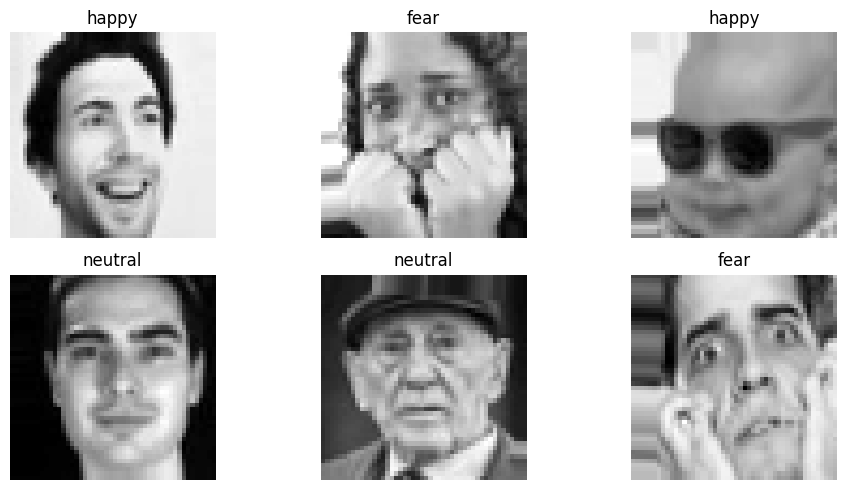

In [49]:
# print out a sample batch
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i].reshape(48, 48), cmap="gray")
    label_index = np.argmax(y_batch[i])
    label_name = list(train_generator.class_indices.keys())[label_index]
    plt.title(label_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Building a CNN Model
Now that we have a good idea of our data set, let's start building our model.

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotion classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

Epoch 1/30
718/718 [==============================] - 20s 26ms/step - loss: 1.8063 - accuracy: 0.2499 - val_loss: 1.7523 - val_accuracy: 0.2790
Epoch 2/30
718/718 [==============================] - 21s 29ms/step - loss: 1.7312 - accuracy: 0.2904 - val_loss: 1.6966 - val_accuracy: 0.2935
Epoch 3/30
718/718 [==============================] - 20s 28ms/step - loss: 1.6511 - accuracy: 0.3413 - val_loss: 1.5478 - val_accuracy: 0.4114
Epoch 4/30
718/718 [==============================] - 20s 27ms/step - loss: 1.5492 - accuracy: 0.3995 - val_loss: 1.4796 - val_accuracy: 0.4233
Epoch 5/30
718/718 [==============================] - 20s 28ms/step - loss: 1.4899 - accuracy: 0.4254 - val_loss: 1.4201 - val_accuracy: 0.4588
Epoch 6/30
718/718 [==============================] - 20s 28ms/step - loss: 1.4397 - accuracy: 0.4510 - val_loss: 1.3922 - val_accuracy: 0.4597
Epoch 7/30
718/718 [==============================] - 20s 28ms/step - loss: 1.4068 - accuracy: 0.4625 - val_loss: 1.3541 - val_accuracy:

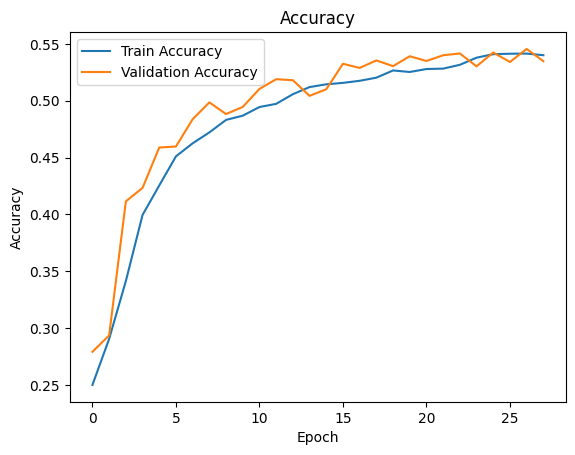

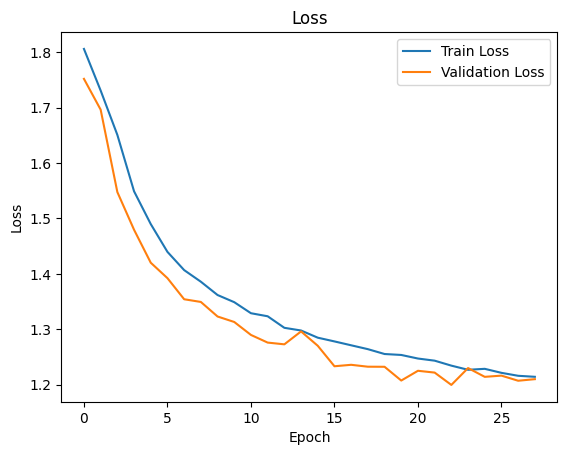

In [51]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop]
)

# Plotting
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

225/225 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

       Angry       0.46      0.46      0.46       958
     Disgust       0.50      0.05      0.08       111
        Fear       0.36      0.21      0.26      1024
       Happy       0.75      0.84      0.79      1774
         Sad       0.47      0.59      0.52      1233
    Surprise       0.44      0.39      0.42      1247
     Neutral       0.65      0.77      0.71       831

    accuracy                           0.56      7178
   macro avg       0.52      0.47      0.46      7178
weighted avg       0.54      0.56      0.54      7178



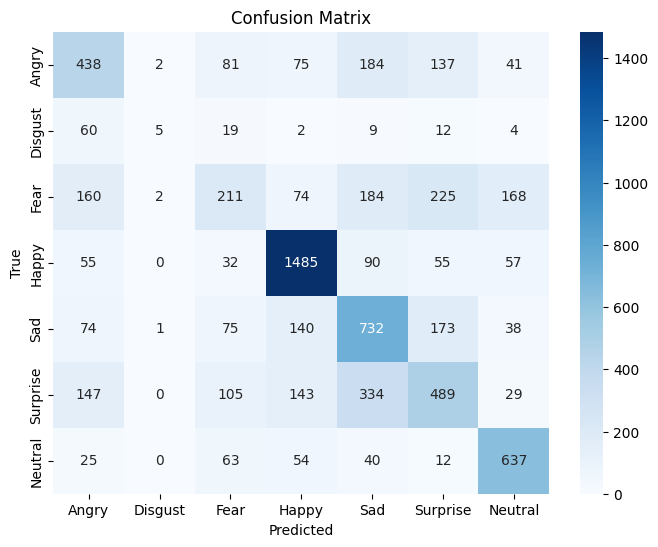

In [52]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=list(emotion_labels.values())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Correct predictions:


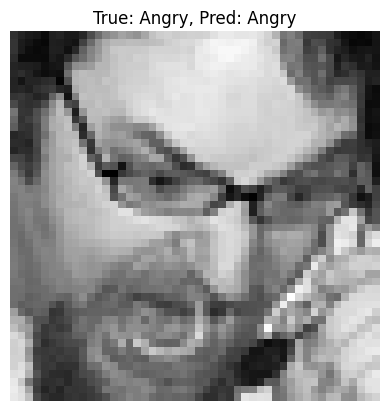

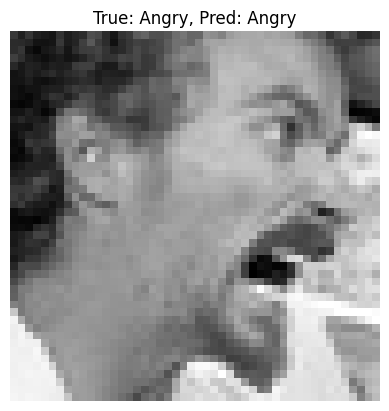

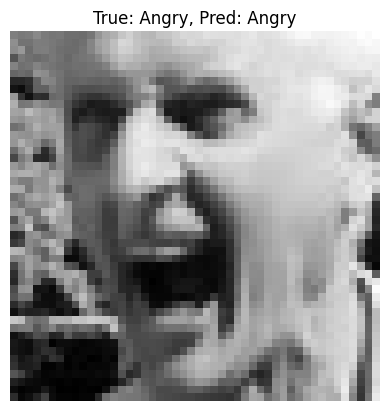

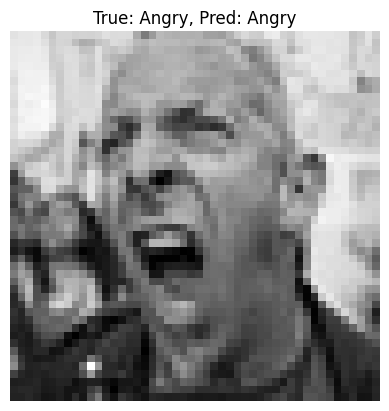

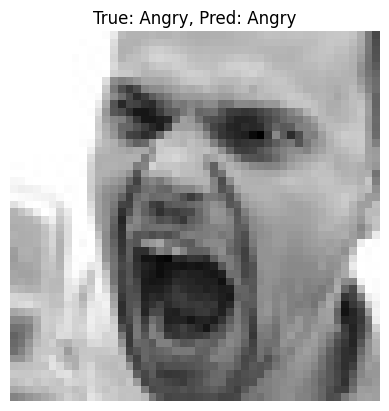

Incorrect predictions:


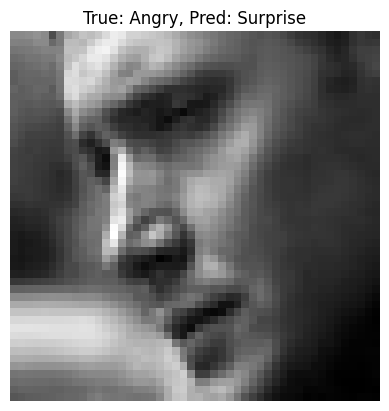

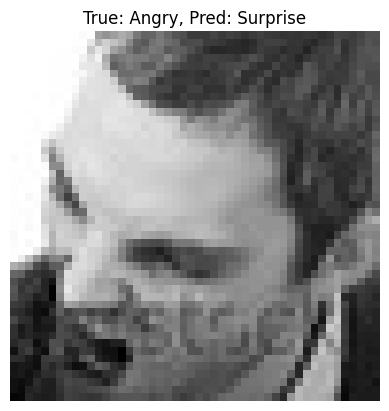

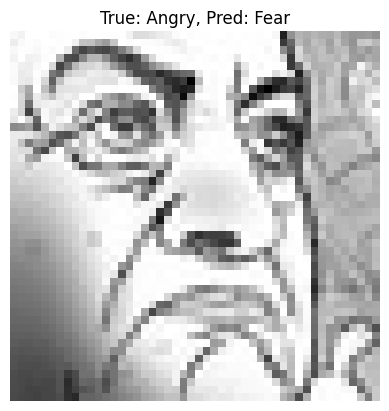

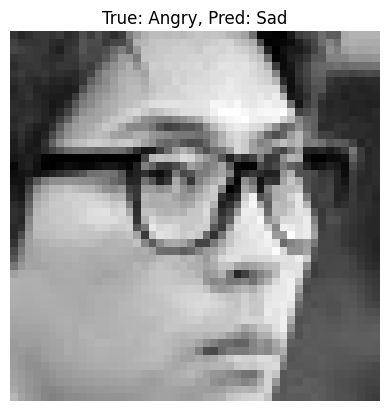

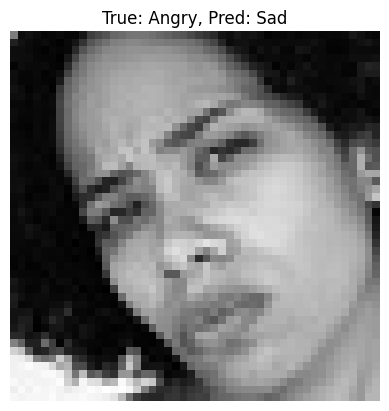

In [53]:
import matplotlib.pyplot as plt

# Get filepaths and labels
filepaths = np.array(test_generator.filepaths)
correct = np.where(y_pred == y_true)[0]
incorrect = np.where(y_pred != y_true)[0]

# Show some correct
print("Correct predictions:")
for i in correct[:5]:
    img = plt.imread(filepaths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {emotion_labels[y_true[i]]}, Pred: {emotion_labels[y_pred[i]]}")
    plt.axis('off')
    plt.show()

# Show some incorrect
print("Incorrect predictions:")
for i in incorrect[:5]:
    img = plt.imread(filepaths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {emotion_labels[y_true[i]]}, Pred: {emotion_labels[y_pred[i]]}")
    plt.axis('off')
    plt.show()